# Solar Locating Tool
### By Areeba Usman & Rose Martin

In [1]:
!pip install -q censusdata

In [2]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
import rioxarray as rxr
from matplotlib_scalebar.scalebar import ScaleBar
from pathlib import Path
import xarray as xr
from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import contextily as ctx
import censusdata
import seaborn as sns
import requests
import zipfile
import shutil
import requests
import rasterio.features 
from shapely.geometry import shape

from rasterio.transform import from_origin
from scipy.spatial import cKDTree

import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

---

## Loading Zone 

---

### Load in States and Flood Plains

In [3]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

## 32048 is the EPSG recommended for Spokane County
states_proj_gdf = states_gdf.to_crs(4326)
WA_idx = states_proj_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_proj_gdf[WA_idx]

#Loads the flood plain data for Spokane
floodplains_fn = './Data/FEMA_Flood_Zone.geojson'
floodplains_gdf = gpd.read_file(floodplains_fn)
floodplains_gdf = floodplains_gdf.set_crs(4326)

### Census Data

In [4]:
#Code taken from lab 5
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]



In [5]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
}

In [6]:
state_fips = '53'  # FIPS code for Washington
county_fips = '063'  # FIPS code for Spokane County

census_df = get_census_data(tables, state_fips, county_fips)
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)

census_Spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf))
census_Spokane_gdf =  census_Spokane_gdf.to_crs('epsg:32610')
#census_df.head()

### Get an AEA Projection centered around Spokane

In [7]:
hull = tract_geom_gdf.geometry.unary_union.convex_hull
cent = hull.centroid

cent_lon =cent.x
cent_lat = cent.y
min_lat = tract_geom_gdf.bounds["miny"].min().item()
max_lat = tract_geom_gdf.bounds["maxy"].max().item()

proj_str_aea = f'+proj=aea +lat_1={min_lat:0.2f} +lat_2={max_lat:0.2f} +lat_0={cent_lat:0.2f} +lon_0={cent_lon:0.2f}'
print(proj_str_aea)

+proj=aea +lat_1=47.26 +lat_2=48.05 +lat_0=47.64 +lon_0=-117.42


/tmp/ipykernel_138/1408670046.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = tract_geom_gdf.geometry.unary_union.convex_hull


### Load the Slope Data

In [8]:
## Get a slope map of Spokane County
dem_data = f'{Path.home()}/gda_demo_data/dem_data'
dem_fn = os.path.join(dem_data, "WA_COP90.tif")
dst_crs = 'EPSG:32610'
proj_fn = os.path.splitext(dem_fn)[0]+'_utm_gdalwarp.tif'
slope_fn = os.path.splitext(proj_fn)[0]+'_slope.tif'

In [9]:
!gdaldem slope $proj_fn $slope_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
slope_ras = rxr.open_rasterio(slope_fn, masked=True).squeeze()

### Substation GDF Creator

In [11]:
#This Code was aquired using the help of ChatGPT
# URL of the ArcGIS FeatureServer
url = "https://services6.arcgis.com/OO2s4OoyCZkYJ6oE/arcgis/rest/services/Substations/FeatureServer/0/query"

# Define query parameters for the request
params = {
    "where": "COUNTY = 'SPOKANE'",  # Filter for records where the STATE field is 'WA'
    "outFields": "*",  # Fetch all fields
    "f": "geojson"  # Request GeoJSON format
}

# Send the request and get the response
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Load the GeoJSON into a GeoDataFrame
    substation_gdf = gpd.read_file(response.text)

else:
    print(f"Failed to fetch data: {response.status_code}")

### Generates Radiation TIF (Does not need to be run more than once)

In [12]:
radiation_fn = "./Data/radiation.tif"
radiation = rxr.open_rasterio(radiation_fn).squeeze()

### Load the Substation Distance TIF

In [13]:
substation_distance_raster_fn = "./Data/distance_raster_proj_alt.tif"
substation_distance_raster_data = rxr.open_rasterio(substation_distance_raster_fn).squeeze()

### Generate Binary Flood Plain Raster

In [14]:
floodplains_gdf = floodplains_gdf.to_crs(proj_str_aea)
tract_geom_gdf =tract_geom_gdf.to_crs(proj_str_aea)

xmin, ymin, xmax, ymax = tract_geom_gdf.total_bounds

# Define the resolution of the raster (in meters)
resolution = 100  # Change this as needed (e.g., 100 meters per pixel)
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

transform = from_origin(xmin, ymax, resolution, resolution)

# Create a binary raster mask of floodplain areas
shapes = [(geom, 1) for geom in floodplains_gdf.geometry]
raster = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype=np.uint8)

# Save raster to file
with rasterio.open(
    "./Data/floodplain_binary.tif", "w", driver="GTiff", height=height, width=width,
    count=1, dtype=np.uint8, crs="EPSG:32610", transform=transform
) as dst:
    dst.write(raster, 1)

In [15]:
floodplain_binary_fn = "./Data/floodplain_binary.tif"
floodplain_binary_data = rxr.open_rasterio(floodplain_binary_fn).squeeze()
floodplain_binary_data = floodplain_binary_data.rio.write_nodata(0)
floodplain_binary_data = floodplain_binary_data.where(floodplain_binary_data != 0) 

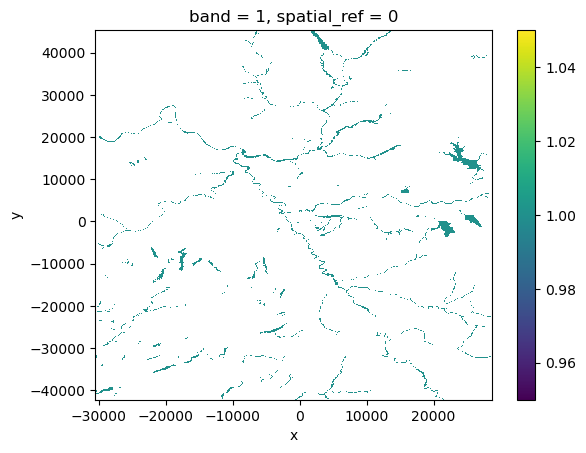

In [16]:
floodplain_binary_data.plot()

### Land Cover

In [17]:
dst_crs = 'EPSG:4326'
land_use_fn = "./Data/land_use.tif"
proj_land_fn = os.path.splitext(land_use_fn)[0]+'_utm_gdalwarp.tif'

In [18]:
!gdalwarp -srcnodata 0 -t_srs $dst_crs $land_use_fn $proj_land_fn

ERROR 4: ./Data/land_use.tif: No such file or directory
ERROR 4: Failed to open source file ./Data/land_use.tif



In [19]:
land_use_da = rxr.open_rasterio(proj_land_fn).squeeze()

### Reproject everything to the same projection

In [20]:
#Set everything to have the same crs as the Spokane census map
slope_ras = slope_ras.rio.reproject(proj_str_aea)

land_use_da = land_use_da.rio.reproject(proj_str_aea)

substation_distance_raster_data = substation_distance_raster_data.rio.reproject(proj_str_aea)

radiation = radiation.rio.reproject(proj_str_aea)

##
census_Spokane_gdf = census_Spokane_gdf.to_crs(proj_str_aea)

tract_geom_gdf = tract_geom_gdf.to_crs(proj_str_aea)

floodplains_gdf = floodplains_gdf.to_crs(proj_str_aea)

substation_gdf = substation_gdf.to_crs(proj_str_aea)

census_geom = census_Spokane_gdf.geometry.unary_union

/tmp/ipykernel_138/2698236284.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  census_geom = census_Spokane_gdf.geometry.unary_union


### If Not Done, Clip All to Spokane County without Parks

In [21]:
slope_Spokane = slope_ras.rio.clip([census_geom])
land_use_da = land_use_da.rio.clip([census_geom])
radiation = radiation.rio.clip([census_geom])
substation_distance_raster_data = substation_distance_raster_data.rio.clip([census_geom])

# LAND USE CLASSES

In [22]:
land_classes = xr.full_like(land_use_da, fill_value=np.nan, dtype=float)

land_classes = xr.where((land_use_da == 190), 1, land_classes)  # Urban Areas
land_classes = xr.where((land_use_da == 200), 2, land_classes)  # Bare Areas
land_classes = xr.where((land_use_da >= 210) & (land_use_da <= 220), 3, land_classes) ## Water/Snow
land_classes = xr.where((land_use_da >= 10) & (land_use_da <= 20), 4, land_classes) ## Farmland
land_classes = xr.where((land_use_da >= 150) & (land_use_da <= 180), 5, land_classes) ## Flood Zone
land_classes = xr.where((land_use_da >= 50) & (land_use_da <= 90), 3, land_classes) # Forest
land_classes = xr.where((land_use_da >= 110) & (land_use_da <= 120) | (land_use_da == 30), 6, land_classes) # Mosaic Vegetation
land_classes = xr.where((land_use_da >= 130) & (land_use_da <= 140) | (land_use_da == 100) | (land_use_da == 40), 2, land_classes) # Transitional Vegetation

---
## XDarry creation

In [23]:
land_classes.rio.write_crs(32610)

<xarray.DataArray (y: 937, x: 634)> Size: 5MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 6.,  6.,  6., ...,  4.,  4.,  4.],
       [nan, nan, nan, ...,  4.,  4.,  4.],
       [nan, nan, nan, ...,  4.,  4.,  4.]])
Coordinates:
  * x            (x) float64 5kB -3.049e+04 -3.04e+04 ... 2.862e+04 2.871e+04
  * y            (y) float64 7kB 4.529e+04 4.52e+04 ... -4.216e+04 -4.225e+04
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [24]:
floodplain_binary_data.name = 'Flood_Zones'
substation_distance_raster_data.name = 'Substation_Distance'
radiation.name = 'Radiation'
land_classes.name = 'Land_Use'
slope_Spokane.name = 'Slope'

In [25]:
merged_df = xr.merge([floodplain_binary_data, substation_distance_raster_data, radiation, land_classes, slope_Spokane])

In [26]:
merged_df

<xarray.Dataset> Size: 316MB
Dimensions:              (x: 2764, y: 4084)
Coordinates:
  * x                    (x) float64 22kB -3.05e+04 -3.049e+04 ... 2.876e+04
  * y                    (y) float64 33kB -4.23e+04 -4.226e+04 ... 4.533e+04
    band                 int64 8B 1
    spatial_ref          int64 8B 0
Data variables:
    Flood_Zones          (y, x) float32 45MB nan nan nan nan ... nan nan nan nan
    Substation_Distance  (y, x) float32 45MB nan nan nan nan ... nan nan nan nan
    Radiation            (y, x) float64 90MB nan nan nan nan ... nan nan nan nan
    Land_Use             (y, x) float64 90MB nan nan nan nan ... nan nan nan nan
    Slope                (y, x) float32 45MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

### Summary Table

In [27]:
st = merged_df.mean()

In [28]:
st = merged_df.to_dataframe().describe()

In [29]:
st

,band,spatial_ref,Flood_Zones,Substation_Distance,Radiation,Land_Use,Slope
count,11288176.0,11288176.0,12749.0,462843.000000,8206.000000,438948.000000,976291.000000
mean,1.0,0.0,1.0,7.291186,0.490309,3.660928,4.507399
std,0.0,0.0,0.0,5.622219,0.003325,1.167461,4.798477
min,1.0,0.0,1.0,0.005182,0.479920,1.000000,0.000000
25%,1.0,0.0,1.0,2.877657,0.488431,3.000000,1.239259
50%,1.0,0.0,1.0,5.782466,0.490070,4.000000,2.763889
75%,1.0,0.0,1.0,10.271069,0.492004,4.000000,5.868117
max,1.0,0.0,1.0,30.254463,0.497737,6.000000,36.703533


---
# MAPS
---

Land Use Plots

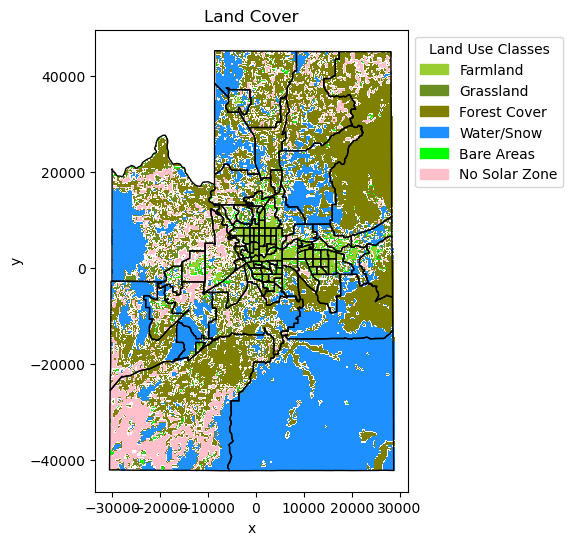

In [30]:
colors = {
    1 : 'yellowgreen', # Farm
    2 : 'olivedrab', # Grassland
    3 : 'olive', # Forest
    4 : 'dodgerblue', # Water/Snow
    5 : 'lime', # Bare Areas
    6 : 'pink' # No Touchyyy
}

cmap = mcolors.ListedColormap([colors[i] for i in range(1, 7)])

norm = mcolors.BoundaryNorm(np.arange(0.5, 7.5, 1), cmap.N)

fig, ax = plt.subplots(figsize=(9, 6))
im = land_classes.plot.imshow(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

legend_patches = [
    Patch(color=colors[1], label='Farmland'),
    Patch(color=colors[2], label='Grassland'),
    Patch(color=colors[3], label='Forest Cover'),
    Patch(color=colors[4], label='Water/Snow'),
    Patch(color=colors[5], label='Bare Areas'),
    Patch(color=colors[6], label='No Solar Zone')
]

tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
ax.legend(handles=legend_patches, bbox_to_anchor=(1, 1), loc='upper left', title='Land Use Classes')
ax.set_title('Land Cover')

plt.show()

In [31]:
land_classes.rio.resolution()

(93.53027821657551, -93.53027821657551)

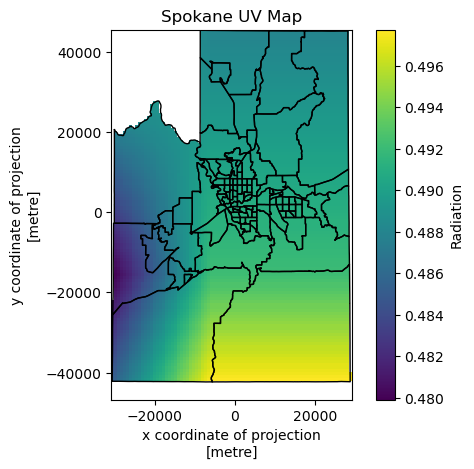

In [32]:
fig,ax = plt.subplots()

radiation.plot.imshow(ax=ax)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

plt.title("Spokane UV Map")
plt.show()

Text(0.5, 0.98, 'Substation distance')

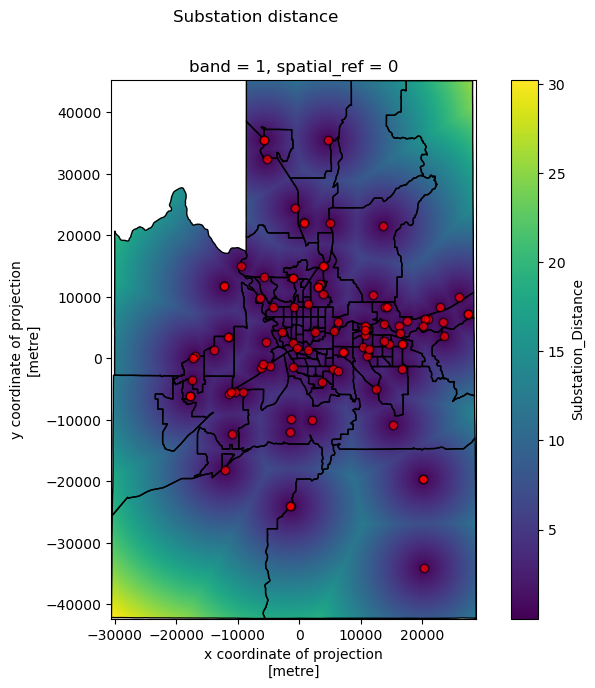

In [33]:
fig,ax = plt.subplots(figsize=(9,7))

substation_distance_raster_data.plot(ax=ax)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

substation_gdf.plot(ax=ax, color='red', edgecolor='k',alpha=0.7)

plt.suptitle('Substation distance')

Spokane Population Density

Slope Map

Flood Plains

Floodplain and Slope Plot Combined

Substation Plot

Radiation Map

Radiation, Subplots and floodplains combined

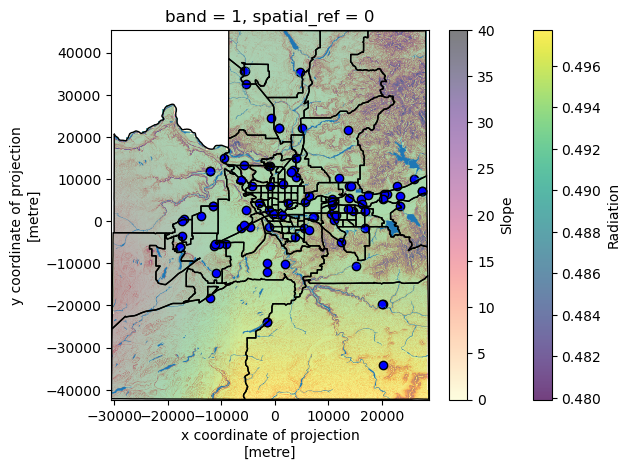

In [34]:

fig,ax = plt.subplots()

substation_gdf.plot(ax=ax, color='blue', edgecolor='black')
radiation.plot.imshow(ax = ax, alpha=0.75)
floodplains_gdf.plot(ax=ax)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
slope_Spokane.plot.imshow(ax=ax, alpha=0.5, vmin=0, vmax = 40,cmap="magma_r")

Flood Plain Raster Plot

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

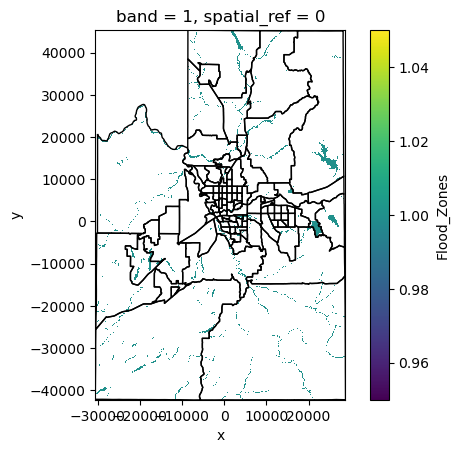

In [35]:
fig,ax = plt.subplots()


floodplain_binary_data.plot(ax = ax)
tract_geom_gdf.plot(ax = ax, edgecolor="black", facecolor = 'none')
